# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [ ]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [ ]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [ ]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [ ]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.02537912  0.02523524 -0.01151945  0.01399305]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [ ]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.02487442 -0.16971964 -0.01123959  0.30301932]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [ ]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 9.0


## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [ ]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

In [ ]:
state_space = 4 # number of states
action_space = 2 # number of possible actions

def Qtable(state_space,action_space,bin_size = 30):
    
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    
    q_table = np.random.uniform(low=-1,high=1,size=([bin_size] * state_space + [action_space]))
    return q_table, bins

def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)
  
def Q_learning(q_table, bins, episodes = 5000, gamma = 0.95, lr = 0.1, timestep = 100, epsilon = 0.2):
    
    rewards = 0
    steps = 0
    for episode in range(1,episodes+1):
        steps += 1 
        # env.reset() => initial observation
        current_state = Discrete(env.reset(),bins)
      
        score = 0
        done = False
        while not done: 
         #if episode%timestep==0: env.render()
         if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
         else:
                action = np.argmax(q_table[current_state])
         observation, reward, done, info = env.step(action)
         next_state = Discrete(observation,bins)
         score+=reward
          
         if not done:
                max_future_q = np.max(q_table[next_state])
                current_q = q_table[current_state+(action,)]
                new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                q_table[current_state+(action,)] = new_q
         current_state = next_state
            
        # End of the loop update
        else:
            rewards += score
            if score > 195 and steps >= 100: print('Solved')
        if episode % timestep == 0: print(reward / timestep)

In [ ]:
q_table,bins = Qtable(state_space,action_space,bin_size = 30)
Q_learning(q_table,bins)
def policy_agent(observation):
  current_state = Discrete(observation,bins)
  action = np.argmax(q_table[current_state])
  return action

0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
Solved
0.01
Solved
Solved
Solved
0.01
Solved
Solved
0.01
Solved
Solved
Solved
Solved
0.01
Solved
0.01
Solved
Solved
Solved
0.01
Solved
0.01
Solved
Solved
Solved
Solved
Solved
0.01
Solved
Solved
Solved
Solved
Solved
0.01
Solved
0.01
0.01
Solved
0.01
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
0.01
Solved
Solved
0.01
Solved
Solved
Solved
Solved
Solved
0.01
Solved
Solved
Solved
Solved
Solved
Solved
0.01
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
0.01
Solved
Solved
Solved
Solved
Solved
Solved
0.01
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
0.01
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
Solved
0.01
Solved
Solved
Solved
Solved
0.01
Solved
Solved
Solved
Solved
Solved
Solved
Solved
0.01
Solved
Solved
Solved
Solved
Solved
Solved
Solved
0.01
Solved
Solved
Solved
Solved
Solved
Solv

For Task 1, we can show the observation and chosen action below:

In [ ]:
observation = env.reset()
action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.04214313 -0.00500244 -0.01085769 -0.03740041]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

### Function to play game for a single episode

In [ ]:
def play_game(env, policy):
  observation = env.reset()

  done = False
  score = 0
  observations = []
  
  while not done:
    observations += [observation.tolist()] # Record the observations for normalization and replay
        
    # Pick an action according to the policy matrix
    #outcome = np.dot(policy, observation)
    outcome = policy_agent(observation)
    action = 1 if outcome > 0 else 0
    
    # Make the action, record reward
    observation, reward, done, info = env.step(action)
    score += reward

  return score, observations

### Function to play game for `size` episodes


In [ ]:
def play_game_episodes(env, policy, size):
  total_score = []
  for i in range (size):
    score, observation = play_game(env, policy)
    total_score.append(score)
  return total_score

### Play game for 100 episodes

In [ ]:
policy = np.random.rand(1,4) #Currently using a random policy - delete this once policy is set in Task 1
episode_results = play_game_episodes(env, policy, 100)
print(episode_results)


[348.0, 222.0, 212.0, 408.0, 417.0, 112.0, 231.0, 314.0, 209.0, 158.0, 299.0, 262.0, 214.0, 39.0, 204.0, 184.0, 371.0, 226.0, 254.0, 193.0, 463.0, 210.0, 255.0, 132.0, 43.0, 220.0, 218.0, 56.0, 240.0, 238.0, 138.0, 293.0, 273.0, 447.0, 220.0, 306.0, 172.0, 61.0, 252.0, 216.0, 332.0, 161.0, 207.0, 98.0, 196.0, 106.0, 231.0, 91.0, 212.0, 184.0, 342.0, 142.0, 355.0, 290.0, 311.0, 284.0, 203.0, 222.0, 112.0, 184.0, 262.0, 357.0, 217.0, 221.0, 314.0, 238.0, 138.0, 181.0, 114.0, 82.0, 80.0, 305.0, 230.0, 136.0, 271.0, 499.0, 385.0, 161.0, 158.0, 420.0, 235.0, 355.0, 210.0, 387.0, 349.0, 252.0, 318.0, 276.0, 361.0, 150.0, 190.0, 35.0, 204.0, 215.0, 412.0, 282.0, 184.0, 197.0, 258.0, 200.0]


### Plot the reward for each round

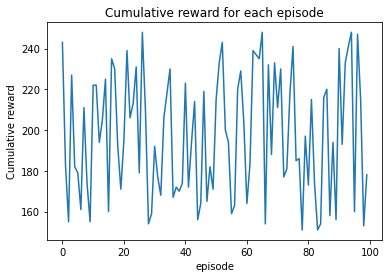

In [ ]:
#episode_results = np.random.randint(150, 250, size=100)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 197.63
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = policy_agent(observation)
    observation, reward, done, info = env.step(action) 
    if done: 
      break;    
env.close()
show_video()